# Baseline: Reflex Control

Steers the car using a PD controller on the estimated $y_m$ track median offset.

In [36]:
from DriveItMultiGym import *
from car import *
from belief import *
import numpy as np
from numpy import pi

num_episodes = 1  # number of episodes to run
time_limit = 10.
throttle_limit = 0.75
gamma = 0.995
epsilon = 0.1
kp, kv = 15.0, 3.0
random_position=True

cars = [Car(Color.black), Car(Color.green), Car(Color.pink)]
pos = [PositionTracking(car.specs) for car in cars]
env = DriveItEnv(cars, time_limit, gamma, noisy=True)
observations = env._reset(random_position)
beliefs = PositionTracking.reset_all(pos, observations)
ym_ = [0.0 for c in cars]
done = False
reward_episode = 0
reward_sum = 0.0
crashes = 0

carpos = []; obs = []; belpos = []; bel = []; err = []

for i_episode in range(1, num_episodes + 1):
    while not done:
        if num_episodes < 2 and time_limit < 60.0:
            env.render()

        actions = []
        for i in range(len(cars)):
            xm, ym, theta, v, K, blue = beliefs[i]
            ym_dot = (ym - ym_[i]) / dt
            ym_[i] = ym
            f = K + kp * ym + kv * ym_dot
            if f > epsilon: action = 2
            elif f < -epsilon: action = 1
            else: action = 0

            if v < 2.5:
                action += 3
            
            actions.append(action)
        
        carpos.append(cars[0].get_position())
        obs.append(observations[0])
        belpos.append(pos[0].position)
        bel.append(beliefs[0])
        e = cars[0].get_position()[:-1] - pos[0].position[:-1]
        e2 = wrap(cars[0].get_position()[2] - beliefs[0][2], -pi, pi)
        err.append((e[0], e[1], e2))

        observations, rewards, done, info = env.step(actions)
        beliefs = PositionTracking.update_all(pos, observations, dt)
        #reward_episode += reward
        #reward_sum = reward + gamma * reward_sum

    if num_episodes <= 10:
        print('Episode %d %s. reward: %f, laps: %f' % \
              (i_episode, info['done'], reward_episode, \
               reward_episode / lap_median_length))

    if info['done'] != 'complete':
        crashes += 1

    reward_sum += reward_episode
    reward_episode = 0
    observations = env._reset(random_position)
    beliefs = PositionTracking.reset_all(pos, observations)
    done = False

if num_episodes > 1:
    print('Average reward: %f with %d crashes' % \
          (reward_sum / num_episodes, crashes))

Episode 1 complete. reward: 0.000000, laps: 0.000000


In [31]:
env.close()

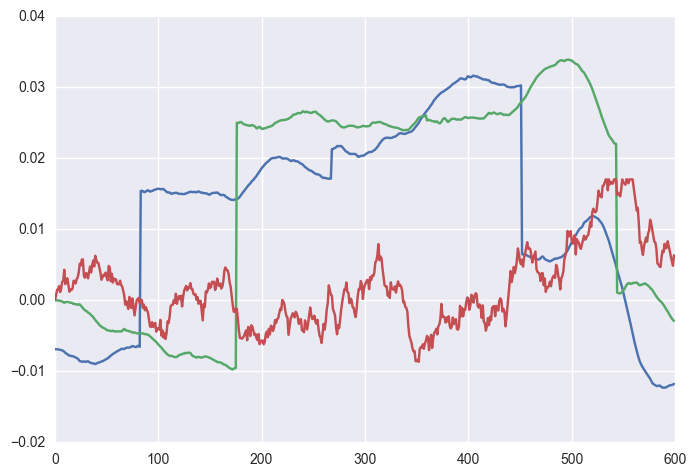

In [37]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')
%matplotlib inline
sns.set()
y = plt.plot([e for e in err])

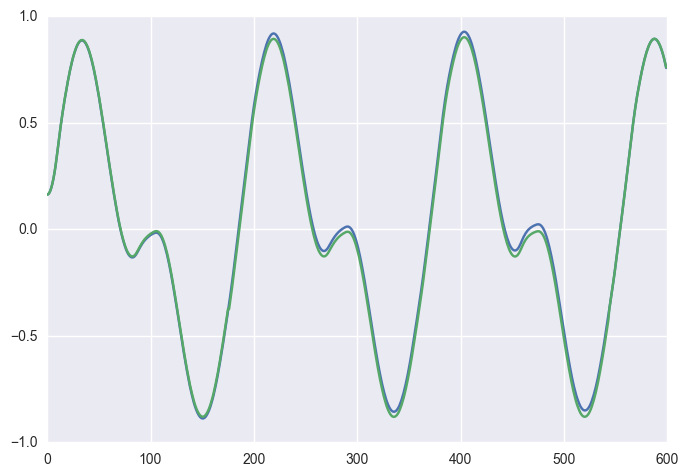

In [38]:
i = 1
y = plt.plot([p[i] for p in carpos])
y = plt.plot([p[i] for p in belpos])

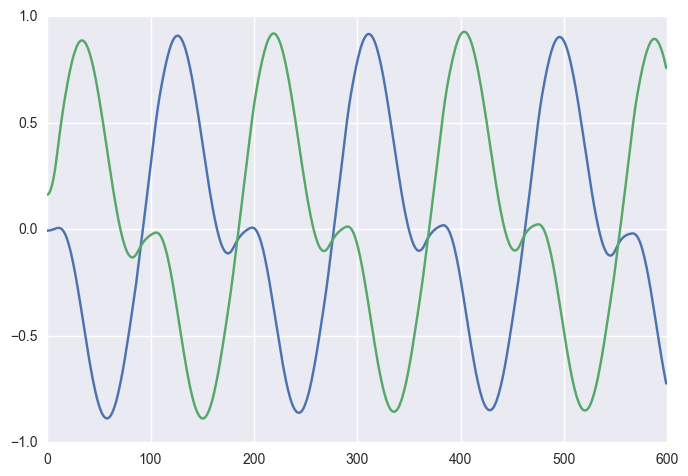

In [39]:
y = plt.plot([p[:-1] for p in carpos])

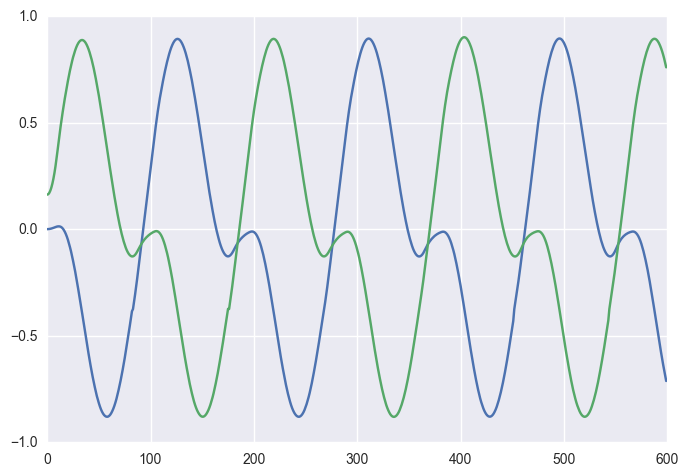

In [40]:
y = plt.plot([p[:-1] for p in belpos])

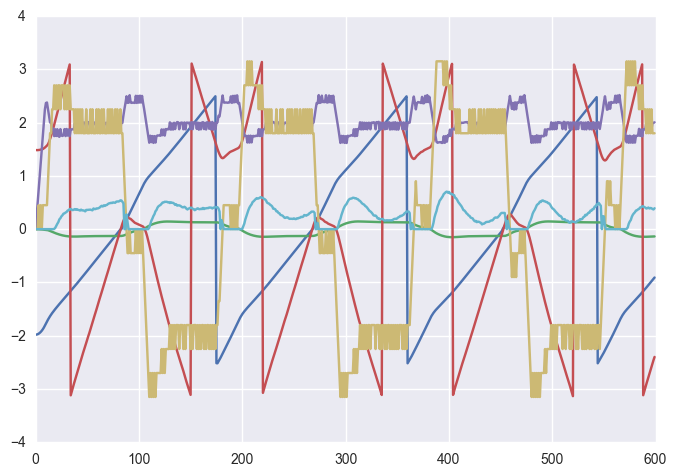

In [41]:
y = plt.plot([b for b in bel])

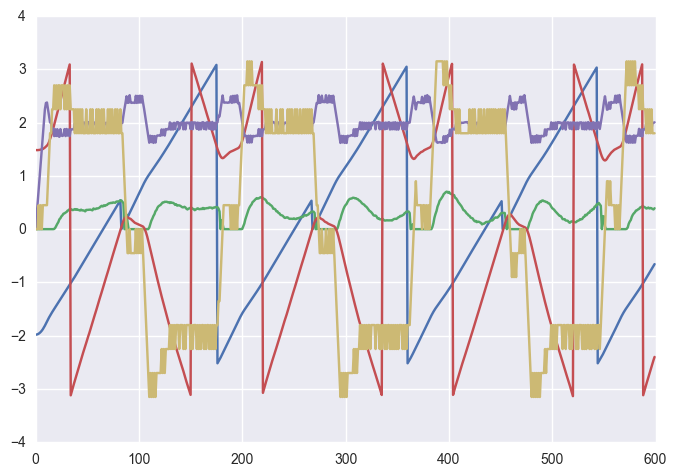

In [42]:
y = plt.plot([o for o in obs])

In [43]:
env._reset(random_position)

[array([ 1.61197276,  0.        , -2.25740695,  0.        , -2.66666667]),
 array([ 0.01446639,  0.        ,  0.00255033,  0.        ,  0.        ]),
 array([ 2.29256165,  0.        ,  2.13672093,  0.        , -3.11666667])]

In [44]:
env.render()

In [45]:
# out penalty = max discounted reward for median laps at full speed
2.5 * dt / (1 - gamma)

8.333333333333325